# Clustering Results

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import time
import sys

# Custom Libraries
sys.path.insert(0, '../dev/')
import ssbplots as cp
import detector

# Suppress all plotting warnings for cleaner visuals
# import warnings
# warnings.filterwarnings('ignore')

# Example Script Usage in Jupyter

In [2]:
# # Sao Tome only has 240 locations
# clusters = ",".join(list(map(str, range(2, 241))))
# clusters

In [3]:
# start = time.time()
# %run -i ../dev/clusters.py -l data_268/stp_cluster_sites_pop.csv -k data_268/kernels -c {clusters} -t 0 -s 42 -e sao_tome_kmeans_t0_exp_268_2-240
# print("Time elapsed: {:.2f} s".format(time.time() - start))

# Using `sao_tome_kmeans_exp()` in mpc_defs.py
# Time elapsed: 706.72 s ~ 11.78 minutes

# Using `kmeans_exp()` in mpc_defs.py
# Time elapsed: 828.37 s ~ 13.81 minutes

# Setup

In [4]:
# NOTE: results were produced using a random state of 42
outputs = {}
with open('outputs/sao_tome_kmeans_t0_exp_268_2-240.pkl', 'rb') as inp:
    outputs = pickle.load(inp)

In [5]:
clusters = list(outputs.keys())
kernels  = list(outputs[clusters[0]].keys())
print("Kernels:")
for k in kernels:
    print(f"\t{k}")

Kernels:
	kernel_1
	kernel_1_2500
	kernel_1_5000
	kernel_2
	kernel_2_2500
	kernel_2_5000


# How does each kernel reach steady state?

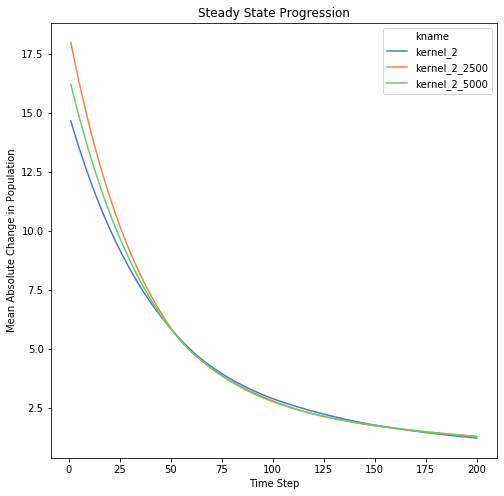

In [6]:
cp.plot_avg_abs_change_in_population(outputs, 
                                     kernels=[
                                         'kernel_2',
                                         'kernel_2_2500',
                                         'kernel_2_5000'
                                     ],
                                     k=201,
                                     final=200)

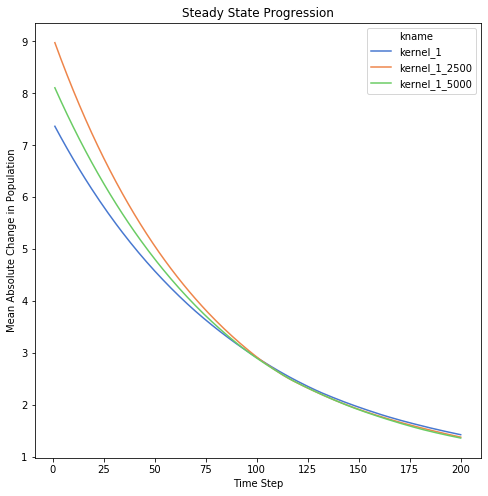

In [7]:
cp.plot_avg_abs_change_in_population(outputs, 
                                     kernels=[
                                         'kernel_1',
                                         'kernel_1_2500',
                                         'kernel_1_5000'
                                     ],
                                     k=201,
                                     final=200)

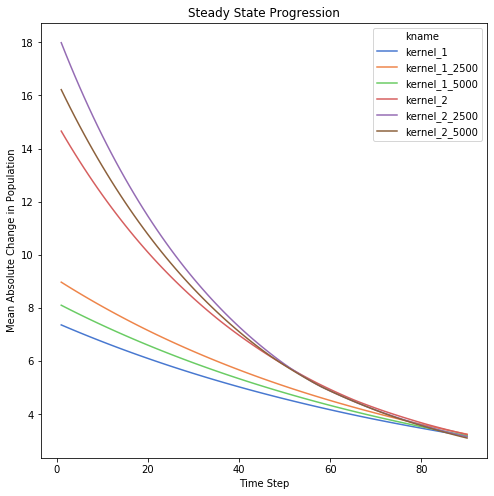

In [8]:
cp.plot_avg_abs_change_in_population(outputs, k=91, final=90)

# How do populations change over time?

In [9]:
custom_range = list(range(0, 50, 5)) +\
               list(range(50, 1000, 100)) +\
               list(range(1000, 7000, 1000))

cp.plot_population_distribution(outputs, "kernel_2_2500", cluster_num=5, k=custom_range)

# Which communities had the largest number nodes?

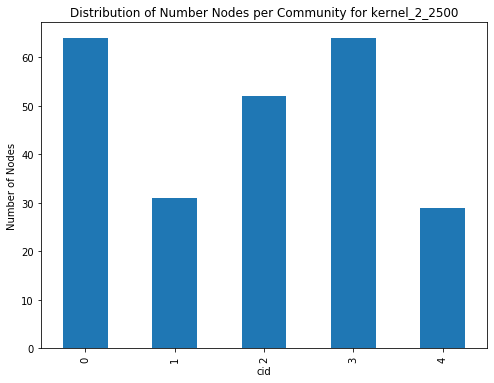

In [10]:
cp.community_nodes_barplot(outputs, 5, "kernel_2_2500")

# Which communities had the largest populations at steady state?

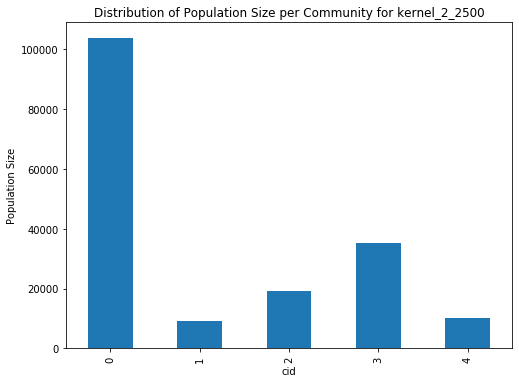

In [11]:
cp.community_populations_barplot(outputs, 5, "kernel_2_2500")

# Do communities with a large number of nodes also have a large population size?

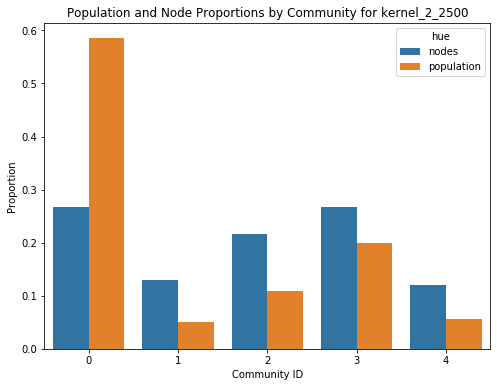

In [12]:
cp.community_proportions_barplot(outputs, 5, "kernel_2_2500", fs=(8, 6))

# How do community population sizes change over time?

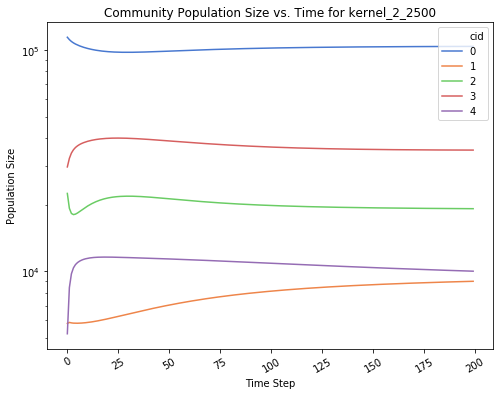

In [13]:
cp.community_populations_lineplot(outputs, 5, "kernel_2_2500")
plt.yscale('log');

# How do the number of sinks/sources/bridges compare across kernels at steady state?

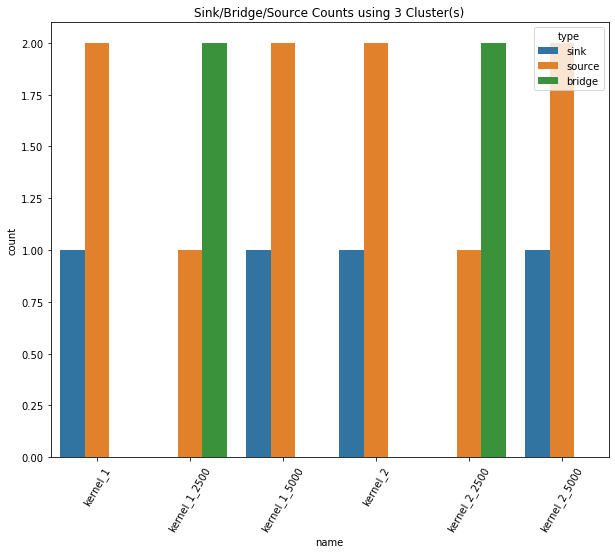

In [14]:
cp.label_counts_barplot(outputs, 3, t=0, fs=(10, 8))

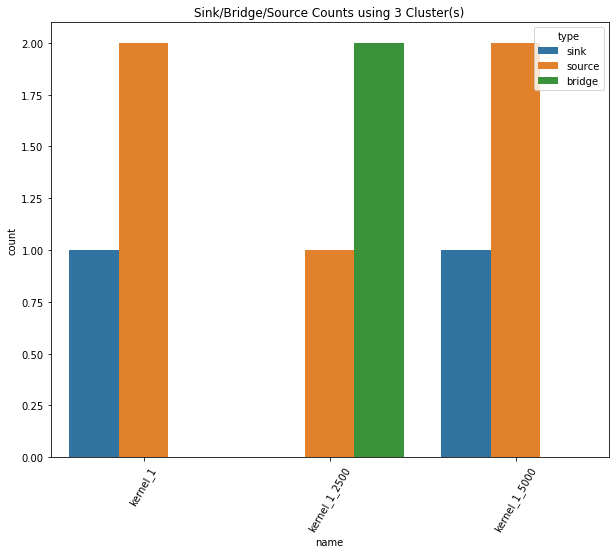

In [15]:
cp.label_counts_barplot(outputs, 3,
                        t=0,
                        kernels=["kernel_1",
                                 "kernel_1_2500",
                                "kernel_1_5000"],
                        fs=(10, 8))

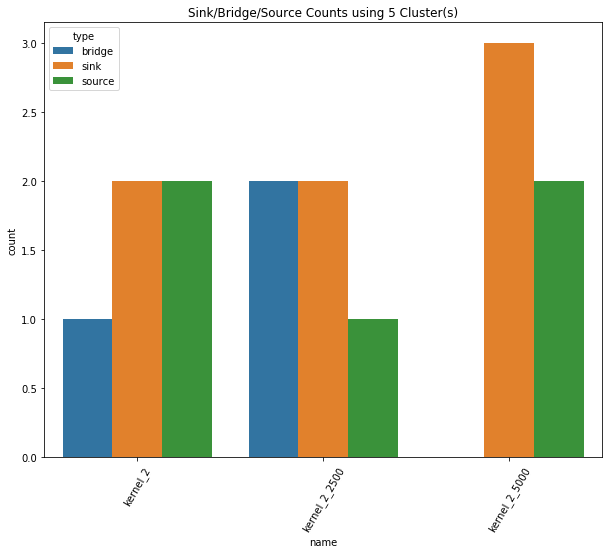

In [16]:
cp.label_counts_barplot(outputs, 5, 
                        t=0,
                        kernels=["kernel_2",
                                 "kernel_2_2500",
                                 "kernel_2_5000"],
                        fs=(10, 8))

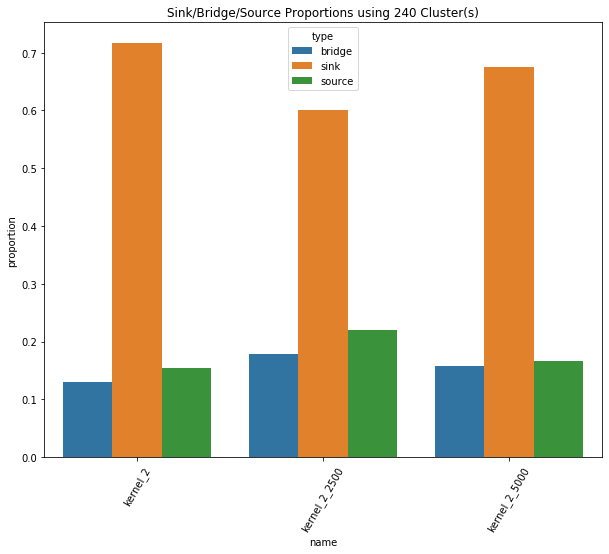

In [17]:
# For larger clustering values, we can examine proportions
cp.label_proportions_barplot(outputs, 240, 
                             t=0,
                             kernels=["kernel_2",
                                      "kernel_2_2500",
                                      "kernel_2_5000"],
                             fs=(10, 8))

# Is there a relationship between the number of clusters and the number of sinks, sources, and bridges?

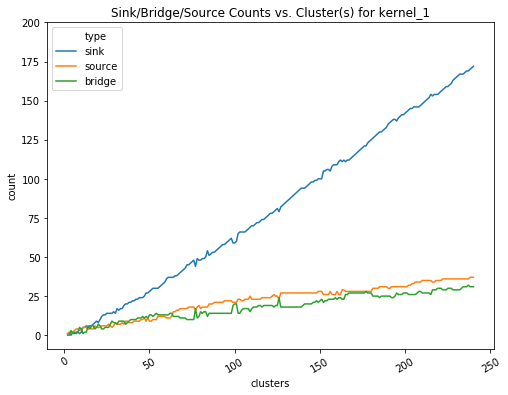

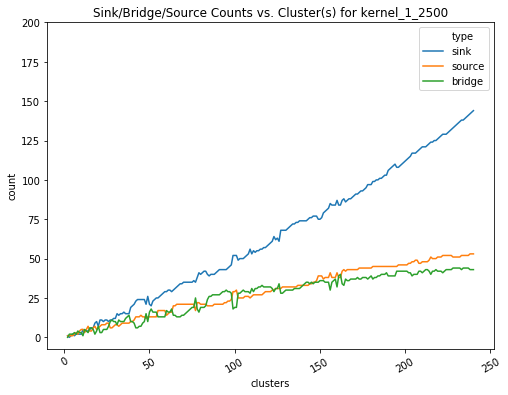

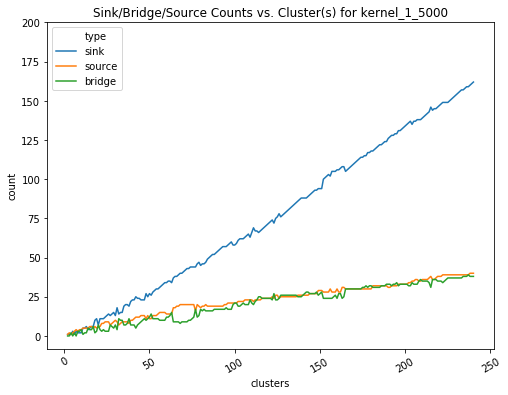

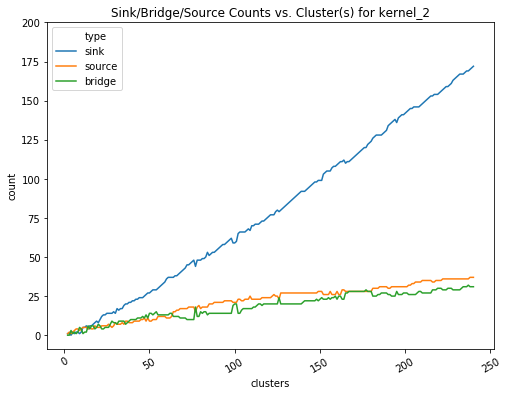

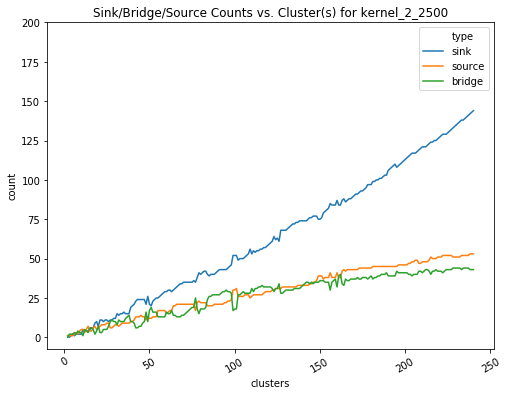

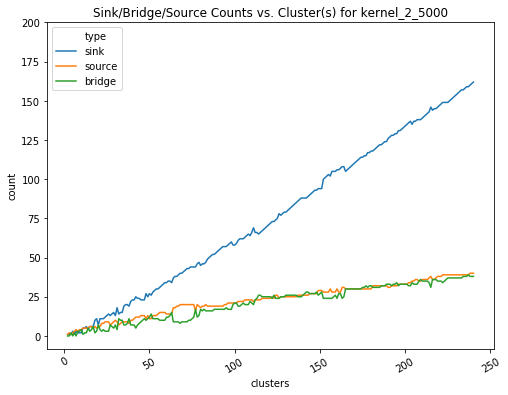

In [18]:
for k in kernels:
    cp.label_counts_lineplot(outputs, k)
    plt.yticks(np.arange(0, 201, 25));

In [19]:
cp.plot_interactive_label_counts(outputs, 'kernel_1')

# Finding the Optimal Number of Clusters

In [20]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [21]:
def sao_tome_best_cluster(k, metric):
    clusters = range(3, len(outputs[2][k].ndata()))
    scores = []
    
    for c in clusters:
        n = outputs[c][k].ndata()
        scores.append((c, metric(n[['lon', 'lat']], n['cid'])))

    vmin, vmax = float('inf'), float('-inf')
    imin, imax = -1, -1
    for i in range(len(scores)):
        s = scores[i][1]
        if vmin > s: vmin = s; imin = i
        if vmax < s: vmax = s; imax = i
            
    return scores[imin], scores[imax]

In [22]:
min_s_score, max_s_score = sao_tome_best_cluster('kernel_1', silhouette_score)
min_d_score, max_d_score = sao_tome_best_cluster('kernel_1', davies_bouldin_score)
max_s_score, min_d_score

((3, 0.4801193525634472), (239, 0.031603959401258784))

In [23]:
best_s_clusters = { k : max_s_score[0] for k in kernels }
best_d_clusters = { k : min_d_score[0] for k in kernels }

In [24]:
best_s_clusters

{'kernel_1': 3,
 'kernel_1_2500': 3,
 'kernel_1_5000': 3,
 'kernel_2': 3,
 'kernel_2_2500': 3,
 'kernel_2_5000': 3}

In [25]:
best_d_clusters

{'kernel_1': 239,
 'kernel_1_2500': 239,
 'kernel_1_5000': 239,
 'kernel_2': 239,
 'kernel_2_2500': 239,
 'kernel_2_5000': 239}

# Number of Sources Using Optimal Clusters

In [26]:
def sao_tome_source_count(d):
    df = pd.DataFrame()
    for k, c in d.items():
        n = outputs[c][k].ndata()
        src = n.groupby('ctype').size()
        if 'source' in src.index.values:
            src = src['source']
            df = pd.concat([df, pd.DataFrame({'name' : [k], 'sources' : [src], 'clusters' : [c]})])
        else:
            df = pd.concat([df, pd.DataFrame({'name' : [k], 'sources' : [0], 'clusters' : [c]})])
    return df.reset_index(drop=True)

df = sao_tome_source_count(best_d_clusters)
df

name  sources  clusters
0       kernel_1       37       239
1  kernel_1_2500       53       239
2  kernel_1_5000       40       239
3       kernel_2       37       239
4  kernel_2_2500       53       239
5  kernel_2_5000       40       239

In [27]:
def highlight_max(x, i, j):
    if x['sources'] == np.max(df[i:j]['sources']):
        return ['background-color: yellow']*len(x)
    else:
        return ['background-color: white']*len(x)

In [28]:
i, j = 0, 3
df[i:j].style.apply(lambda x: highlight_max(x, i, j), axis=1)

In [29]:
i, j = 3, None
df[i:j].style.apply(lambda x: highlight_max(x, i, j), axis=1)

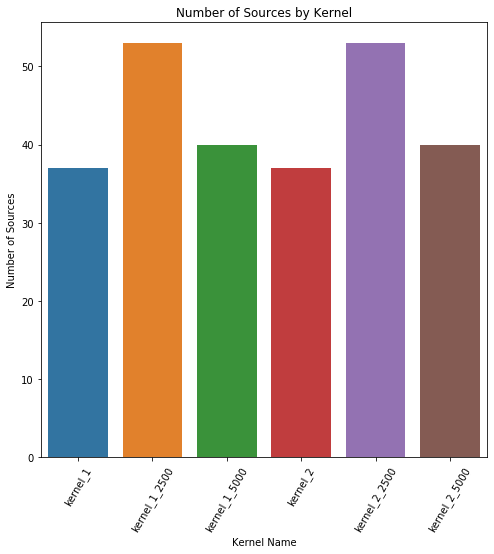

In [30]:
plt.figure(figsize=(8, 8))
sns.barplot(x='name', y='sources', data=df)
plt.ylabel('Number of Sources')
plt.xlabel('Kernel Name')
plt.title('Number of Sources by Kernel')
plt.xticks(rotation=60);

# What clustering results in the maximum number of nodes being classified as sources?

In [31]:
df = pd.concat([cp.get_label_counts(outputs, c, kernels=kernels) for c in outputs])\
       .reset_index()\
       .rename(columns={'level_1' : 'type'})
df = df[df['type'] == 'source']

In [32]:
df = df.loc[df.groupby('name').apply(lambda r: r['count'].idxmax())]\
       .reset_index(drop=True)\
       .rename(columns={'count' : 'sources'})
df

name    type  sources  clusters
0       kernel_1  source       37       238
1  kernel_1_2500  source       53       238
2  kernel_1_5000  source       40       238
3       kernel_2  source       37       238
4  kernel_2_2500  source       53       238
5  kernel_2_5000  source       40       238

In [33]:
i, j = 0, 3
df[i:j].drop('type', axis=1).style.apply(lambda x: highlight_max(x, i, j), axis=1)

In [34]:
i, j = 3, None
df[i:j].drop('type', axis=1).style.apply(lambda x: highlight_max(x, i, j), axis=1)

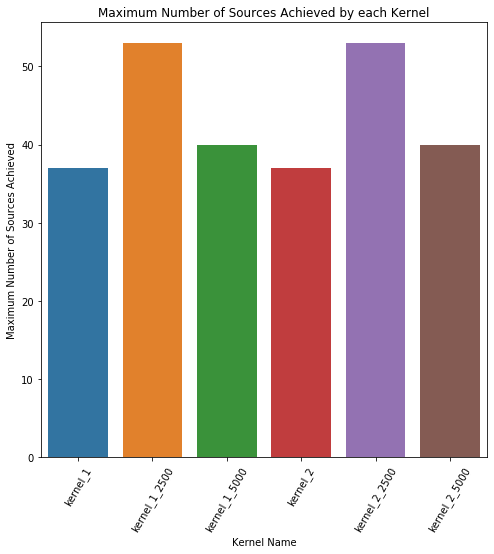

In [35]:
plt.figure(figsize=(8, 8))
sns.barplot(x='name', y='sources', data=df)
plt.ylabel('Maximum Number of Sources Achieved')
plt.xlabel('Kernel Name')
plt.title('Maximum Number of Sources Achieved by each Kernel')
plt.xticks(rotation=60);

# Flow Comparisons

In [36]:
for k in kernels:
    c = outputs[3][k].cdata()
    print(k, "\nTotal flow out:", np.sum(c['num_out']))
    display(c)
    print("\n\n")

kernel_1 
Total flow out: 42.645082087509515


num_in    num_out    prp_in   prp_out    type
cid                                                  
0    33.117883   9.527199  0.776593  0.223407    sink
1     6.836077  12.071683  0.361549  0.638451  source
2     2.691122  21.046200  0.113371  0.886629  source




kernel_1_2500 
Total flow out: 9.016749930079573


num_in   num_out    prp_in   prp_out    type
cid                                                
0    5.136597  3.880153  0.569673  0.430327  bridge
1    3.182615  3.421556  0.481910  0.518090  bridge
2    0.697537  1.715041  0.289125  0.710875  source




kernel_1_5000 
Total flow out: 23.607064227659652


num_in    num_out    prp_in   prp_out    type
cid                                                  
0    17.770464   5.836601  0.752760  0.247240    sink
1     4.069188   7.178327  0.361786  0.638214  source
2     1.767412  10.592136  0.143000  0.857000  source




kernel_2 
Total flow out: 85.56964412194395


num_in    num_out    prp_in   prp_out    type
cid                                                  
0    66.505031  19.064613  0.777204  0.222796    sink
1    13.702333  24.110456  0.362373  0.637627  source
2     5.362279  42.394576  0.112283  0.887717  source




kernel_2_2500 
Total flow out: 18.06538276422141


num_in   num_out    prp_in   prp_out    type
cid                                                 
0    10.262632  7.802750  0.568083  0.431917  bridge
1     6.404685  6.820168  0.484292  0.515708  bridge
2     1.398065  3.442465  0.288825  0.711175  source




kernel_2_5000 
Total flow out: 47.30544016987086


num_in    num_out    prp_in   prp_out    type
cid                                                  
0    35.593934  11.711506  0.752428  0.247572    sink
1     8.175960  14.290625  0.363916  0.636084  source
2     3.535546  21.303308  0.142339  0.857661  source

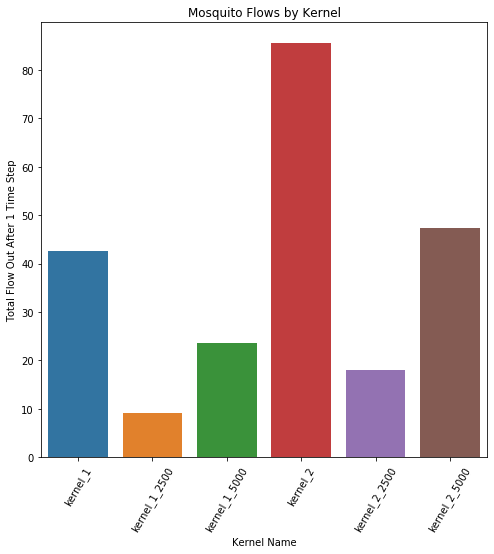

In [37]:
flow = [np.sum(outputs[3][k].cdata()['num_out']) for k in kernels]

plt.figure(figsize=(8, 8))
sns.barplot(x=kernels, y=flow)
plt.ylabel('Total Flow Out After 1 Time Step')
plt.xlabel('Kernel Name')
plt.title('Mosquito Flows by Kernel')
plt.xticks(rotation=60);

# Network Plots

In [38]:
import matplotlib.cm as cmx
import geojson

# To plot a background, convert the SHP file(s) to a geojson file
# Use: https://mygeodata.cloud/converter/shp-to-geojson
with open("geojson/STP.geojson") as json_file:
    json_data = geojson.load(json_file)
    
sao_tome_geo = [json_data['features'][1]]
principe_geo = [json_data['features'][0]]
both_loc_geo = json_data['features']

In [39]:
# This will add nonnegative Gaussian noise to the edges to make them easier to see
def jitter_edges(weights, mean=0, stddev=1):
    return weights + np.abs(np.random.normal(mean, stddev, size=len(weights)))

KERNEL_NAME = 'kernel_1_2500'
CLUSTER_NUM = 3

In [40]:
# This retrieves the required parameters for `plot_netowrk`
s = outputs[CLUSTER_NUM][KERNEL_NAME]
nodes = s.ndata()

sao_tome_locs = nodes
sao_tome_tmtx = s.tmtx.T

In [41]:
# Create copy for exploration
st_locs = sao_tome_locs.copy()

In [42]:
# Get location populations at steady state
st_locs['pop'] = s.migrate(s.ss_step)[sao_tome_locs.index]

cp.plot_network(sao_tome_tmtx, st_locs,
                nodes_cm=cmx.get_cmap('cool')   , nodes_cb=False,
                edges_cm=cmx.get_cmap('Purples'), edges_cb=True,
                bordr_cm=cmx.get_cmap('gray')   , bordr_cb=True,
                cb_xlocs=[1.02, 1.15],
                min_prob=0.001,
                edges_fn=jitter_edges,
                geo_data=sao_tome_geo,
                fig_wdth=650, fig_hght=600)

In [43]:
# Get location populations at steady state
st_locs['pop'] = s.migrate(s.ss_step)[sao_tome_locs.index]

cp.plot_network(sao_tome_tmtx, st_locs,
                nodes_cm=cmx.get_cmap('rainbow'), nodes_cb=True,
                edges_cm=cmx.get_cmap('Purples'), edges_cb=False,
                bordr_cm=cmx.get_cmap('gray')   , bordr_cb=False,
                cb_xlocs=[1.02], n_offset=0.325,
                nodes_fn=lambda n: [7] * len(n),
                bordr_fn=lambda b: [0] * len(b),
                min_prob=1,
                geo_data=sao_tome_geo,
                fig_wdth=650, fig_hght=600)

In [44]:
# Separate into two categories: source and sink/bridge
st_locs['ctype'] = st_locs['ctype'].map({'source' : 'source', 'sink' : 'sink/bridge', 'bridge' : 'sink/bridge'})

# Color all nodes the same
st_locs['cid'] = 0

In [45]:
cp.plot_network(sao_tome_tmtx, st_locs,
                nodes_cm=cmx.get_cmap('gist_gray')   , nodes_cb=False,
                edges_cm=cmx.get_cmap('Purples'), edges_cb=False,
                bordr_cm=cmx.get_cmap('cool')   , bordr_cb=True,
                shufflec=True,
                rng_seed=42, #47, #45,
                cb_xlocs=[1.02],
                min_prob=1,
                nodes_fn=lambda n: [1] * len(n),
                bordr_fn=lambda b: [8] * len(b),
                edges_fn=lambda e: np.exp(e),
                geo_data=sao_tome_geo,
                fig_wdth=650, fig_hght=600)

In [46]:
cp.plot_network(sao_tome_tmtx, st_locs,
                nodes_cm=cmx.get_cmap('gist_gray'), nodes_cb=False,
                edges_cm=cmx.get_cmap('Purples')  , edges_cb=True,
                bordr_cm=cmx.get_cmap('cool'), bordr_cb=True,
                cb_xlocs=[1.02, 1.2],
                min_prob=0.0010,
#                 max_prob=0.0010,
                nodes_fn=lambda n: [1] * len(n),
                bordr_fn=lambda b: [4] * len(b),
                edges_fn=lambda e: np.exp(e),
                geo_data=sao_tome_geo,
                netwk_bg='#252525',
                paper_bg='#c2c2c2',
                fig_wdth=650, fig_hght=600)